### En este notebook se entrenan diferentes modelos predictivos usando la puntuación OASIS para predecir si una estancia en UCI va a ser > 3 días o no. Luego se evalua el rendimiento de los modelos con ACC, AUC-ROC, AUC-PR, confusion matrix....

Obs. Ejecute primero '03calculateOASIS.ipynb' para obtener 'result_24_horas_final.csv'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pylab
import seaborn as sns
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import os

matplotlib.style.use('ggplot')

In [2]:
result_24_horas_final=pd.read_csv('result_24_horas_final.csv')

In [3]:
result_24_horas_final.isnull().sum()

Unnamed: 0.1          0
Unnamed: 0            0
SUBJECT_ID            0
HADM_ID               0
ADMITTIME             0
ADMISSION_TYPE        0
ICUSTAY_ID            0
INTIME                0
LOS                  10
AGE                   0
PRELOS                0
OASIS             13655
OASIS_NONAN           0
dtype: int64

In [4]:
result_24_horas_final = result_24_horas_final[result_24_horas_final['LOS'].notnull()] 
result_24_horas_final.isnull().sum()

Unnamed: 0.1          0
Unnamed: 0            0
SUBJECT_ID            0
HADM_ID               0
ADMITTIME             0
ADMISSION_TYPE        0
ICUSTAY_ID            0
INTIME                0
LOS                   0
AGE                   0
PRELOS                0
OASIS             13645
OASIS_NONAN           0
dtype: int64

In [5]:
#Excluir admissions < 18 years old, ya que tendran medidas fisiológicas distintas de las de los adultos 
result_24_horas_final = result_24_horas_final[~(result_24_horas_final['AGE'] < 18)]

In [6]:
print(result_24_horas_final.shape)
print('unique SUBJECT_ID:', result_24_horas_final.SUBJECT_ID.nunique())
print('unique HADM_ID   :', result_24_horas_final.HADM_ID.nunique())
print('unique ICUSTAY_ID   :', result_24_horas_final.ICUSTAY_ID.nunique())
result_24_horas_final.head()

(53329, 13)
unique SUBJECT_ID: 38510
unique HADM_ID   : 49692
unique ICUSTAY_ID   : 53329


,Unnamed: 0.1,Unnamed: 0,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,ICUSTAY_ID,INTIME,LOS,AGE,PRELOS,OASIS,OASIS_NONAN
1,1,0,1472,161232,2107-09-26 15:46:00,EMERGENCY,244372,2107-10-01 21:58:11,0.8297,80.646575,126.2,35.0,35.0
2,2,0,81875,143469,2193-09-03 19:30:00,EMERGENCY,238281,2193-09-03 19:30:45,1.0088,77.698630,0.0,24.0,24.0
4,4,0,56209,117730,2179-09-04 08:18:00,EMERGENCY,228215,2179-09-04 08:19:18,3.5205,18.254795,0.0,42.0,42.0
5,5,0,5056,156002,2171-05-01 17:29:00,EMERGENCY,210815,2171-05-16 09:39:01,5.1987,39.641096,352.2,NaN,29.0
6,6,0,19228,138019,2193-07-23 18:49:00,EMERGENCY,240880,2193-07-26 17:57:04,2.8694,51.241096,71.1,19.0,19.0


Duration for each single icustay_id is the LOS measured in days. LOS_C are computed by binarization.

In [7]:
result_24_horas_final['LOS']=np.where(result_24_horas_final['LOS']>3, 1, 0) # 0 "estancia corta", 1 "estancia larga"
print(result_24_horas_final.shape)
result_24_horas_final.head()

(53329, 13)


,Unnamed: 0.1,Unnamed: 0,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,ICUSTAY_ID,INTIME,LOS,AGE,PRELOS,OASIS,OASIS_NONAN
1,1,0,1472,161232,2107-09-26 15:46:00,EMERGENCY,244372,2107-10-01 21:58:11,0,80.646575,126.2,35.0,35.0
2,2,0,81875,143469,2193-09-03 19:30:00,EMERGENCY,238281,2193-09-03 19:30:45,0,77.698630,0.0,24.0,24.0
4,4,0,56209,117730,2179-09-04 08:18:00,EMERGENCY,228215,2179-09-04 08:19:18,1,18.254795,0.0,42.0,42.0
5,5,0,5056,156002,2171-05-01 17:29:00,EMERGENCY,210815,2171-05-16 09:39:01,1,39.641096,352.2,NaN,29.0
6,6,0,19228,138019,2193-07-23 18:49:00,EMERGENCY,240880,2193-07-26 17:57:04,0,51.241096,71.1,19.0,19.0


### Predecir en 24  horas  (considerando los oasis_variable nan como 0.0 (usar np.nansum), i.e. en rango 'normal') + mismo cohorte que benchmark

In [8]:
result_24_horas_nonnan=result_24_horas_final[['LOS','OASIS_NONAN','ICUSTAY_ID']]
result_24_horas_nonnan.head()

,LOS,OASIS_NONAN,ICUSTAY_ID
1,0,35.0,244372
2,0,24.0,238281
4,1,42.0,228215
5,1,29.0,210815
6,0,19.0,240880


In [9]:
result_24_horas_nonnan['LOS'].value_counts()

0    33797
1    19532
Name: LOS, dtype: int64

In [10]:
#from sklearn.model_selection import train_test_split
#from sklearn import preprocessing
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)http://localhost:8888/notebooks/TFG/code/final_versiones_OASIS_mismoCohorteBenchmark/OASIS_final_3daysLOS.ipynb#

Normalmente basta con train_test_split para tener conjunto de entrenamiento (Train set) y conjunto de prueba (Test set). Pero como queremos comparar con otros modelos, recomienda mantener un mismo Test set. Por lo tanto, usamos ficheros llamados 'listfilexx' para poder rastrear el Test/Train set. (obs. estas listfiles se obtienen ejecutando create_losxdays_icustayidListfiles.py)

In [11]:
cohorte_test_benchmark = pd.read_csv('/data/codi/OASIS/lengthOfStay/test/listfileLos3.csv')
cohorte_test_benchmark.rename(columns={'icustayid': 'ICUSTAY_ID'}, inplace=True)
print(cohorte_test_benchmark.shape)
cohorte_test_benchmark.head()

(5282, 3)


,stay,y_true,ICUSTAY_ID
0,10000_episode1_timeseries.csv,0,247610
1,10011_episode1_timeseries.csv,1,232110
2,10012_episode1_timeseries.csv,0,277998
3,10019_episode1_timeseries.csv,0,228977
4,10026_episode1_timeseries.csv,0,277021


In [12]:
test_set=pd.merge(cohorte_test_benchmark, result_24_horas_nonnan, how='left', on=['ICUSTAY_ID'])
print(test_set.shape)
test_set.head()

(5282, 5)


,stay,y_true,ICUSTAY_ID,LOS,OASIS_NONAN
0,10000_episode1_timeseries.csv,0,247610,0,26.0
1,10011_episode1_timeseries.csv,1,232110,1,27.0
2,10012_episode1_timeseries.csv,0,277998,0,27.0
3,10019_episode1_timeseries.csv,0,228977,0,48.0
4,10026_episode1_timeseries.csv,0,277021,0,34.0


In [13]:
test_set.isnull().sum()

stay           0
y_true         0
ICUSTAY_ID     0
LOS            0
OASIS_NONAN    0
dtype: int64

In [14]:
test_set[test_set['y_true'] == test_set['LOS']].shape

(5282, 5)

In [15]:
#We can see that they have same LOS, all correct
test_set[~(test_set['y_true'] == test_set['LOS'])]

,stay,y_true,ICUSTAY_ID,LOS,OASIS_NONAN


In [16]:
#Solo hace falta ejecutar esta linea una vez, que genera listfile para modelos con times_series
#test_set['ICUSTAY_ID'].to_csv('/home/usuario/TFG/code/final_versiones_OASIS_mismoCohorteBenchmark/lengthOfStay/test/listfile.csv', index=False,header='ICUSTAY_ID')

In [17]:
X_test=pd.DataFrame(test_set['OASIS_NONAN'])
y_test=pd.DataFrame(test_set['LOS'])

In [18]:
cohorte_train_benchmark = pd.read_csv('/data/codi/OASIS/lengthOfStay/train/listfileLos3.csv')
cohorte_train_benchmark.rename(columns={'icustayid': 'ICUSTAY_ID'}, inplace=True)
print(cohorte_train_benchmark.shape)
cohorte_train_benchmark.head()

(29846, 3)


,stay,y_true,ICUSTAY_ID
0,91051_episode1_timeseries.csv,0,209804
1,19208_episode2_timeseries.csv,0,208696
2,41432_episode1_timeseries.csv,0,229628
3,65089_episode1_timeseries.csv,0,263325
4,17882_episode4_timeseries.csv,0,269666


In [19]:
train_set=pd.merge(cohorte_train_benchmark, result_24_horas_nonnan, how='left', on=['ICUSTAY_ID'])
print(train_set.shape)
train_set.head()

(29846, 5)


,stay,y_true,ICUSTAY_ID,LOS,OASIS_NONAN
0,91051_episode1_timeseries.csv,0,209804,0,20.0
1,19208_episode2_timeseries.csv,0,208696,0,30.0
2,41432_episode1_timeseries.csv,0,229628,0,30.0
3,65089_episode1_timeseries.csv,0,263325,0,44.0
4,17882_episode4_timeseries.csv,0,269666,0,24.0


In [20]:
train_set.isnull().sum()

stay           0
y_true         0
ICUSTAY_ID     0
LOS            0
OASIS_NONAN    0
dtype: int64

In [21]:
train_set[train_set['y_true'] == train_set['LOS']].shape

(29846, 5)

In [22]:
#Solo hace falta ejecutar esta linea una vez, que genera listfile para modelos con times_series
#train_set['ICUSTAY_ID'].to_csv('/home/usuario/TFG/code/final_versiones_OASIS_mismoCohorteBenchmark/lengthOfStay/train/listfile.csv', index=False,header='ICUSTAY_ID')

In [23]:
X_train=pd.DataFrame(train_set['OASIS_NONAN'])
y_train=pd.DataFrame(train_set['LOS'])

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
X_train

array([[-1.22720012],
       [-0.22210936],
       [-0.22210936],
       ...,
       [ 0.17992694],
       [ 0.58196324],
       [ 1.9890903 ]])

In [26]:
X_test

array([[-0.62414567],
       [-0.52363659],
       [-0.52363659],
       ...,
       [-1.22720012],
       [ 0.17992694],
       [-0.42312751]])

## Visualization

In [55]:
from sklearn.decomposition import PCA
import plotly.express as px
# Plotting the Clusters using matplotlib
pca = PCA(4)
print(X_train.shape)
components = pca.fit_transform(X_train)
print(components.shape)
print(pca.explained_variance_ratio_)

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(2),
    color=y_train
)
fig.update_traces(diagonal_visible=False)
fig.show()

(29846, 1)


ValueError: n_components=4 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
components = tsne.fit_transform(X_train)
print(components.shape)

In [ ]:
df = pd.DataFrame()
df["y"] = y_train
df['tsne-one'] = components[:,0]
df['tsne-two'] = components[:,1] 

sns.scatterplot(x="tsne-one", y="tsne-two", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="OASIS data T-SNE projection") 

## Models

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Silhouette
silhouette_coefficients = []
kmeans_kwargs= {
    "init":"random",
    "n_init":10,
    "max_iter":300,
    "random_state":42
}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train)
    score = silhouette_score(X_train, kmeans.labels_)
    silhouette_coefficients.append(score)

# Plotting graph to choose the best number of clusters
# with the most Silhouette Coefficient score
print(silhouette_coefficients)
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
# KMeans K=2
n_clusters = 2
kmeans = KMeans(
    init="random",
    n_clusters=n_clusters,
    n_init=10,
    max_iter=300,
    random_state=42
)
# Fit to the training data
kmeans.fit(X_train)
train_df = pd.DataFrame(X_train)
# Generate out clusters
train_cluster = kmeans.predict(X_train)
n_columns = X_train.shape[1]

# Add predicted cluster and y regression label to our training DataFrame
train_df.insert(n_columns,'cluster', train_cluster)
train_df.insert(n_columns+1,'y', y_train) 
train_clusters_df = []
for i in range(n_clusters):
    train_clusters_df.append(train_df[train_df['cluster']==i])

# Random Forest
logreg=RandomForestClassifier(n_estimators=10, random_state = 42)
k_logregs = []

In [ ]:
# One model for each cluster
print("-------- Logistic Regression fitting for each cluster --------")
for cluster_df in train_clusters_df:
    cluster_X = cluster_df.iloc[:,:n_columns] # X values
    cluster_Y = cluster_df.iloc[:,n_columns+1] # Y value
    logreg.fit(cluster_X, cluster_Y)
    k_logregs.append(logreg)
    print("Training cluster shape: ", cluster_df.shape)

In [ ]:
# Test sample es asignado al cluster correspondiente mediante Distancia euclidiana y se aplica el modelo correspondiente
print("Assigning each test sample to the closest cluster centroid...")
test_df = pd.DataFrame(X_test)
test_clusters_df = test_df.copy()
test_clusters_df["cluster"] = None
test_clusters_df.insert(n_columns+1,'y', y_test) 
i=0
for row in test_df.itertuples(index=False):
    min_distance = float('inf')
    closest_cluster = None
    for k in range(kmeans.cluster_centers_.shape[0]):
        # Check if the assigned cluster has more than 100 samples
        # if train_clusters_df[k].shape[0] > 100: # Probar sin limite
        distance = np.linalg.norm(kmeans.cluster_centers_[k]-row)
        if distance < min_distance:
            min_distance = distance
            closest_cluster = k
    # Assign cluster to test sample
    test_clusters_df.iloc[i, n_columns] = closest_cluster
    i += 1

test_clusters = []
for i in range(n_clusters):
    test_cluster_i = test_clusters_df[test_clusters_df['cluster']==i]
    if np.size(test_cluster_i) != 0:
        test_clusters.append(test_cluster_i)
        print("Test cluster shape: ", test_cluster_i.shape)

In [ ]:
def print_metrics_binary(y_true, predictions, verbose=1):
    predictions = np.array(predictions)
    if len(predictions.shape) == 1:
        predictions = np.stack([1 - predictions, predictions]).transpose((1, 0))

    cf = metrics.confusion_matrix(y_true, predictions.argmax(axis=1))
    if verbose:
        print("confusion matrix:")
        print(cf)
    cf = cf.astype(np.float32)

    acc = (cf[0][0] + cf[1][1]) / np.sum(cf)
    prec0 = cf[0][0] / (cf[0][0] + cf[1][0])
    prec1 = cf[1][1] / (cf[1][1] + cf[0][1])
    rec0 = cf[0][0] / (cf[0][0] + cf[0][1])
    rec1 = cf[1][1] / (cf[1][1] + cf[1][0])
    auroc = metrics.roc_auc_score(y_true, predictions[:, 1])

    (precisions, recalls, thresholds) = metrics.precision_recall_curve(y_true, predictions[:, 1])
    auprc = metrics.auc(recalls, precisions)
    minpse = np.max([min(x, y) for (x, y) in zip(precisions, recalls)])

    if verbose:
        print("accuracy = {}".format(acc))
        print("precision class 0 = {}".format(prec0))
        print("precision class 1 = {}".format(prec1))
        print("recall class 0 = {}".format(rec0))
        print("recall class 1 = {}".format(rec1))
        print("AUC of ROC = {}".format(auroc))
        print("AUC of PRC = {}".format(auprc))
        print("min(+P, Se) = {}".format(minpse))

    return {"acc": acc,
            "prec0": prec0,
            "prec1": prec1,
            "rec0": rec0,
            "rec1": rec1,
            "auroc": auroc,
            "auprc": auprc,
            "minpse": minpse}

In [ ]:
print("-------- Train metrics ---------")
i = 0
# For each cluster, predict probabilities of class labels
for cluster_df in train_clusters_df:
    cluster_X = cluster_df.iloc[:,:n_columns] # X values
    cluster_Y = cluster_df.iloc[:,n_columns+1] # Y value
    classes_prob = k_logregs[i].predict_proba(cluster_X)
    if i == 0:
        train_X_probs = np.array(classes_prob)
        y_train = np.array(cluster_Y)
    else: 
        train_X_probs = np.concatenate((train_X_probs, classes_prob))
        y_train = np.concatenate((y_train, cluster_Y))
    i += 1
# Print and save the results
ret = print_metrics_binary(y_train, train_X_probs)        


# Test metrics
print("-------- Test metrics ---------")
i = 0
# For each cluster, predict probabilities of class labels
for cluster_df in test_clusters:
    cluster_X = cluster_df.iloc[:,:n_columns] # X values
    cluster_Y = cluster_df.iloc[:,n_columns+1] # Y value
    classes_prob = k_logregs[i].predict_proba(cluster_X)[:,1]
    if i == 0:
        test_X_probs = np.array(classes_prob)
        y_test = np.array(cluster_Y)
    else: 
        test_X_probs = np.concatenate((test_X_probs, classes_prob))
        y_test = np.concatenate((y_test, cluster_Y))
    i += 1
# Print and save the results
ret = print_metrics_binary(y_test, test_X_probs)

Random Forest same class weight

In [28]:
clf=RandomForestClassifier(n_estimators=10, random_state = 42)
clf.fit(X_train,np.ravel(y_train))
y_pred=clf.predict(X_test)
test_ac=np.round(metrics.accuracy_score(y_test, y_pred)*100,4)
train_ac=np.round(clf.score(X_train, y_train)*100,4)
print("Accuracy test:",test_ac)
print("Accuracy train:",train_ac)

Accuracy test: 65.0511
Accuracy train: 64.9032


In [29]:
y_pred_probas=clf.predict_proba(X_test)
y_pred_probas #probability of being [class 0, class 1]

array([[0.72525449, 0.27474551],
       [0.70960555, 0.29039445],
       [0.70960555, 0.29039445],
       ...,
       [0.79327636, 0.20672364],
       [0.59381375, 0.40618625],
       [0.68767047, 0.31232953]])

In [30]:
y_pred_probas[:, 1] #probability of being class 1(LOS>3)
#Nota: usamos probabilities para calculo de auc_roc. Porque en el benchmark usa probabilities y además
#el resultado de auc_roc varia si usa probilidad o valores enteros de 0/1.

array([0.27474551, 0.29039445, 0.29039445, ..., 0.20672364, 0.40618625,
       0.31232953])

In [31]:
np.array(np.ravel(y_test))

array([0, 1, 0, ..., 0, 0, 0])

In [32]:
auroc = metrics.roc_auc_score(y_test, y_pred_probas[:, 1])
print("AUC-ROC: ", auroc)
(precisions, recalls, thresholds) = metrics.precision_recall_curve(y_test, y_pred_probas[:, 1])
auprc = metrics.auc(recalls, precisions)
print("AUC-PR: ", auprc)

AUC-ROC:  0.6590811326344301
AUC-PR:  0.5435824269359687


In [33]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)

[[2824  416]
 [1430  612]]


Mirando confusion matrix, ahora estan mas balanceado, el accuracy bajo.

In [34]:
cm = metrics.confusion_matrix(y_test, y_pred)
score = np.round(clf.score(X_test, y_test)*100,4)

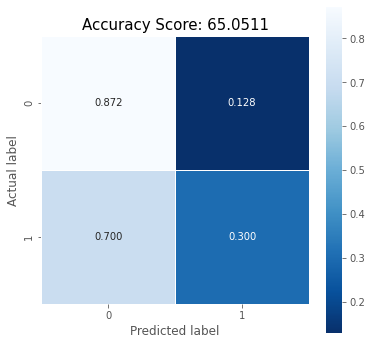

In [35]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)
plt.show()

In [36]:
def save_results(pred, y_true, path):
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(path, 'w') as f:
        f.write("prediction,y_true\n")
        for (x, y) in zip(pred, y_true):
            f.write("{:.6f},{}\n".format(x, y))

In [37]:
predictions_output_dir = '/data/codi/OASIS/lengthOfStay'

In [38]:
save_results(y_pred_probas[:, 1], np.array(np.ravel(y_test)), os.path.join(predictions_output_dir, 'test_predictions', 'RF.csv'))

Random Forest different class weight

In [39]:
clf=RandomForestClassifier(n_estimators=10, random_state = 42,class_weight='balanced')
clf.fit(X_train,np.ravel(y_train))
y_pred=clf.predict(X_test)
test_ac=np.round(metrics.accuracy_score(y_test, y_pred)*100,4)
train_ac=np.round(clf.score(X_train, y_train)*100,4)
print("Accuracy test:",test_ac)
print("Accuracy train:",train_ac)

Accuracy test: 61.5676
Accuracy train: 61.9916


In [40]:
y_pred_probas=clf.predict_proba(X_test)
auroc = metrics.roc_auc_score(y_test,  y_pred_probas[:, 1])
print("AUC-ROC: ", auroc)
(precisions, recalls, thresholds) = metrics.precision_recall_curve(y_test,  y_pred_probas[:, 1]) #same as benchmark
auprc = metrics.auc(recalls, precisions)
print("AUC-PR: ", auprc)

AUC-ROC:  0.6590933755335486
AUC-PR:  0.5435136643102615


In [41]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)

[[1990 1250]
 [ 780 1262]]


In [42]:
cm = metrics.confusion_matrix(y_test, y_pred)
score = np.round(clf.score(X_test, y_test)*100,4)

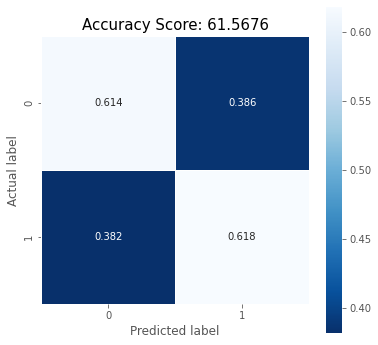

In [43]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)
plt.show()

In [44]:
save_results(y_pred_probas[:, 1], np.array(np.ravel(y_test)), os.path.join(predictions_output_dir, 'test_predictions', 'RF_weighted.csv'))

Logistic Regression same class weight

In [45]:
logreg = LogisticRegression()
logreg.fit(X_train, np.ravel(y_train))
y_pred = logreg.predict(X_test)
actr=np.round(100*logreg.score(X_train, y_train),4)
acte=np.round(100*logreg.score(X_test, y_test),4)
print('Accuracy of logistic regression classifier on train set:', actr)
print('Accuracy of logistic regression classifier on test set:', acte)

Accuracy of logistic regression classifier on train set: 64.7691
Accuracy of logistic regression classifier on test set: 65.089


In [46]:
y_pred_probas=logreg.predict_proba(X_test)
auroc = metrics.roc_auc_score(y_test,  y_pred_probas[:, 1])
print("AUC-ROC: ", auroc)
(precisions, recalls, thresholds) = metrics.precision_recall_curve(y_test,  y_pred_probas[:, 1])
auprc = metrics.auc(recalls, precisions)
print("AUC-PR: ", auprc)

AUC-ROC:  0.6565577350938926
AUC-PR:  0.5367460527554307


In [47]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)

[[2881  359]
 [1485  557]]


In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.89      0.76      3240
           1       0.61      0.27      0.38      2042

    accuracy                           0.65      5282
   macro avg       0.63      0.58      0.57      5282
weighted avg       0.64      0.65      0.61      5282



In [49]:
save_results(y_pred_probas[:, 1], np.array(np.ravel(y_test)), os.path.join(predictions_output_dir, 'test_predictions', 'LR.csv'))

Logistic Regression different class weight

In [50]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, np.ravel(y_train))
y_pred = logreg.predict(X_test)
actr=np.round(100*logreg.score(X_train, y_train),4)
acte=np.round(100*logreg.score(X_test, y_test),4)
print('Accuracy of logistic regression classifier on train set:', actr)
print('Accuracy of logistic regression classifier on test set:', acte)

Accuracy of logistic regression classifier on train set: 62.0653
Accuracy of logistic regression classifier on test set: 61.719


In [51]:
y_pred_probas=logreg.predict_proba(X_test)
auroc = metrics.roc_auc_score(y_test, y_pred_probas[:, 1])
print("AUC-ROC: ", auroc)
(precisions, recalls, thresholds) = metrics.precision_recall_curve(y_test, y_pred_probas[:, 1])
auprc = metrics.auc(recalls, precisions)
print("AUC-PR: ", auprc)

AUC-ROC:  0.6565577350938926
AUC-PR:  0.5367460527554307


In [52]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)

[[2020 1220]
 [ 802 1240]]


In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.62      0.67      3240
           1       0.50      0.61      0.55      2042

    accuracy                           0.62      5282
   macro avg       0.61      0.62      0.61      5282
weighted avg       0.63      0.62      0.62      5282



In [54]:
save_results(y_pred_probas[:, 1], np.array(np.ravel(y_test)), os.path.join(predictions_output_dir, 'test_predictions', 'LR_weighted.csv'))